<h1>Honorifics Data Analysis</h1>

In [1]:
# import needed packages
from functions import *

# read in data
data = pd.read_csv("data_honorifics.csv")
p52 = data[data['ID']=='P52'].index[0]
data = data.drop(p52)

# random seed for clustering
randomSeed = 5

<h2>Part One: Clustering Based on Mapped Values</h2>
For the first try at clustering the honorifics data, I created a vocab list and mapped each answer to a number. Then clustered the dataset from there. The benefits of this approach are that it's easy to implement and easy to use for clustering. The drawbacks are that using Kmeans to cluster will probably result in slightly skewed clustering since numbers that are closer to each other will be treated as more similar (which is not necessarily true since the numbers have very little meaning in this context). This issue will be addressed in the second section.

In [2]:
# isolate the question portion of the dataset
questions = data.iloc[:,7:24]
questions = questions.fillna("I don't know")

vocab = []
qcols = []
# get questions column names
for question in range(1,18):
    qcols.append("Q"+str(question))


For each column, we create a dictionary to map values from strings to numbers. Then we put the mapped values into a new dataframe that we can use for further analysis.

In [3]:
# make a dict to map words to numbers
df = pd.DataFrame()
for col in qcols:
    dict = {}
    for i in range(len(questions[col].unique())):
        dict[questions[col].unique()[i]] = i
    df[col] = questions[col].map(dict)
    
df = df.fillna(dict["I don\'t know"])

df

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  Q11  Q12  Q13  Q14  Q15  Q16  Q17
0    0   0   0   0   0   0   0   0   0    0    0    0    0    0    0    0    0
1    1   0   0   0   0   0   0   0   0    0    1    1    0    0    1    0    0
2    0   1   0   1   1   0   1   1   1    1    2    2    0    0    2    1    1
3    0   0   0   0   0   0   2   0   0    2    2    3    0    1    1    1    2
4    0   0   0   0   0   0   0   0   0    0    0    0    0    0    3    0    0
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...
62   0   1   0   1   2   0   3   2   2    1    1    2    0    0    1    0    1
63   0   0   0   0   0   0   3   0   0    0    2    3    0    4    1    3    3
64   0   0   0   0   0   0   0   0   0    0    0    0    0    2    0    3    0
65   0   0   0   0   0   0   3   0   1    0    2    3    0    1    1    3    3
66   1   0   0   0   0   0   0   0   0    0    2    0    0    2    0    0    0

[66 rows x 17 columns]

Now that we have our new dataframe, we can perform clustering (using Kmeans). We begin by looking at the inertias of different kmeans cluster numbers to determine an appropriate number of clusters for our data. As you can see from the below graph, there is no clear elbow. Further analysis will all be performed on sets of 6 clusters.

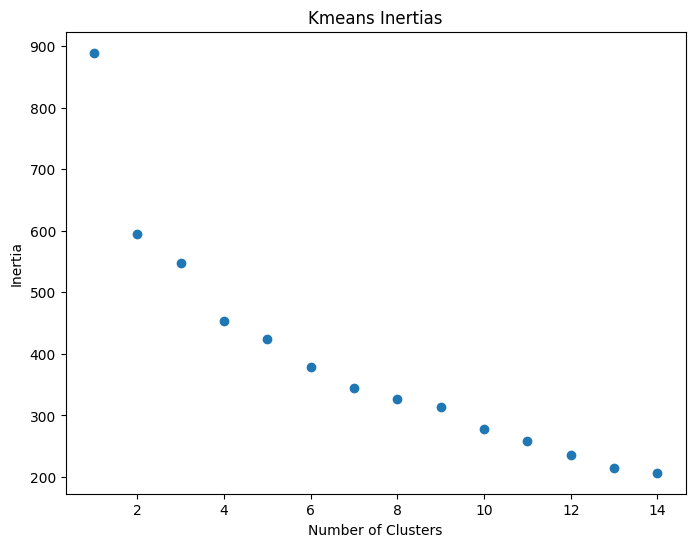

In [4]:
# graph cluster inertias for 1-15 clusters
clusterDf = doKmeans(df,range(1,15),randomSeed=randomSeed)

<h3>Age Across Clusters</h3>
Now that we have clusters to work with, we can see if there are any age differences between clusters of responses. As you can tell, there are some age differences between clusters, and there is a significant difference in ages between the clusters. Cluster 5 has a significantly higher age than the other clusters. However when we look more closely at the data, there are only 2 values in cluster 5 that have ages attached, so this is not a strong conclusion.

In [5]:
# add age to the cluster df
clusterDf["Age"]=data["Age"]
# print the cluster sets for 6 clusters
rows6 = printClusterSetAge(clusterDf,6)
for i in range(len(rows6)):
    rows6[i] = rows6[i].dropna()

print(f_oneway(*rows6,nan_policy="omit"))
#print(tukey_hsd(*rows6))

Cluster 0
mean: 20.833333333333332

Cluster 1
mean: 24.352941176470587

Cluster 2
mean: 28.22222222222222

Cluster 3
mean: 28.2

Cluster 4
mean: 26.8125

Cluster 5
mean: 53.333333333333336

F_onewayResult(statistic=5.073776190112251, pvalue=0.000773491082493332)


To further confirm these results, we do the same analysis on 2, 4, and 8 clusters of the data.

In [6]:
print("Two Clusters: ")
rows2 = printClusterSetAge(clusterDf,2)
print("--------------------------------\nFour Clusters: ")
rows4 = printClusterSetAge(clusterDf,4)
print("--------------------------------\nEight Clusters: ")
rows8 = printClusterSetAge(clusterDf,8)

Two Clusters: 
Cluster 0
mean: 29.473684210526315

Cluster 1
mean: 26.027027027027028

--------------------------------
Four Clusters: 
Cluster 0
mean: 29.75

Cluster 1
mean: 26.1

Cluster 2
mean: 29.272727272727273

Cluster 3
mean: 25.941176470588236

--------------------------------
Eight Clusters: 
Cluster 0
mean: 21.75

Cluster 1
mean: 24.41176470588235

Cluster 2
mean: 23.0

Cluster 3
mean: 55.75

Cluster 4
mean: 30.0

Cluster 5
mean: 27.0

Cluster 6
mean: 25.5

Cluster 7
mean: 19.0



Below is the statistical analyses of the age for 2, 4, and 8 clusters. The 8 cluster is also statistically significant, but once again there are only two values that are useful in the cluster, so it is hard to draw conclusions.

In [7]:
# ttest on clusters ages
# no significant
print(ttest_ind(list(rows2[0]),list(rows2[1]),nan_policy="omit"))
print(f_oneway(*rows4,nan_policy="omit"))
print(f_oneway(*rows8,nan_policy="omit"))

TtestResult(statistic=1.0635244326345794, pvalue=0.292277078094199, df=54.0)
F_onewayResult(statistic=0.366263105423472, pvalue=0.7776304762039823)
F_onewayResult(statistic=7.614914864323189, pvalue=3.646629231114878e-06)


<h2>Part Two: Clustering Based on One Hot Encoding</h2>
In order to address the concerns from the mapping (where numbers that are close by will be clustered closer), we will then map the data using one-hot-encoding principals. Each question will be split into several columns with a column for each possible response, and the columns will simply contain binary data. The idea is that since the questions are now represented with binary data, all the numbers are equally distant from one another. We will repeat the same clustering process with the one-hot-encoded data.

In [8]:
encoded = pd.DataFrame()
for col in questions.columns:
    for val in questions[col].unique():
        encoded[col+"-"+val]=(questions[col]==val).map({True: 1, False: 0})
encoded

Q1-Grandma  Q1-Thought  Q2-stone  Q2-I don't know  Q2-Listener  \
0            1           0         1                0            0   
1            0           1         1                0            0   
2            1           0         0                1            0   
3            1           0         1                0            0   
4            1           0         1                0            0   
..         ...         ...       ...              ...          ...   
62           1           0         0                1            0   
63           1           0         1                0            0   
64           1           0         1                0            0   
65           1           0         1                0            0   
66           0           1         1                0            0   

    Q3-Teacher  Q4-Teacup  Q4-I don't know  Q4-Listener  Q5-stone  ...  \
0            1          1                0            0         1  ...   
1            1          1                0            0         1  ...   
2            1          0                1            0         0  ...   
3            1          1                0            0         1  ...   
4            1          1                0            0         1  ...   
..         ...        ...              ...          ...       ...  ...   
62           1          0                1            0         0  ...   
63           1          1                0            0         1  ...   
64           1          1                0            0         1  ...   
65           1          1                0            0         1  ...   
66           1          1                0            0         1  ...   

    Q16-Murderer  Q16-Mother  Q16-Other  Q16-Listener  Q16-I don't know  \
0              1           0          0             0                 0   
1              1           0          0             0                 0   
2              0           1          0             0                 0   
3              0           1          0             0                 0   
4              1           0          0             0                 0   
..           ...         ...        ...           ...               ...   
62             1           0          0             0                 0   
63             0           0          0             1                 0   
64             0           0          0             1                 0   
65             0           0          0             1                 0   
66             1           0          0             0                 0   

    Q17-Car  Q17-I don't know  Q17-Father  Q17-Listener  Q17-B  
0         1                 0           0             0      0  
1         1                 0           0             0      0  
2         0                 1           0             0      0  
3         0                 0           1             0      0  
4         1                 0           0             0      0  
..      ...               ...         ...           ...    ...  
62        0                 1           0             0      0  
63        0                 0           0             1      0  
64        1                 0           0             0      0  
65        0                 0           0             1      0  
66        1                 0           0             0      0  

[66 rows x 65 columns]

Once again we then perform Kmeans for a number of cluster values, and graph the inertias.

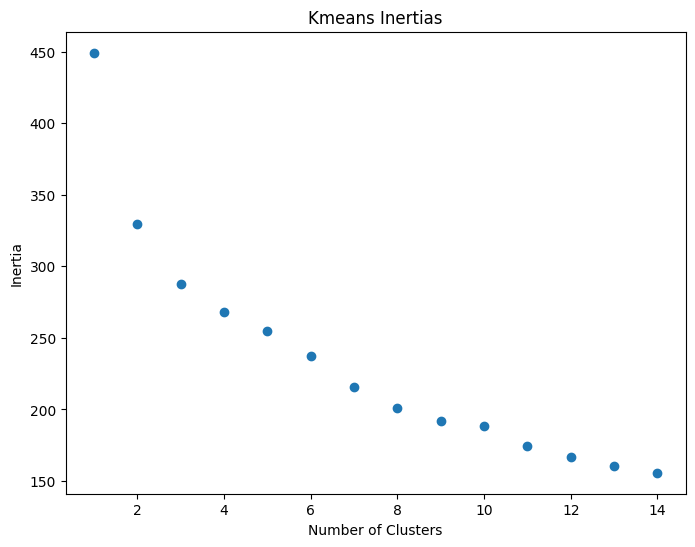

In [9]:
# graph cluster inertias for 1-15 clusters
encodedClusters = doKmeans(encoded,range(1,15),randomSeed=randomSeed)

### No Significant Age Differences Across Clusters
Now we can once again look at some of the cluster sets and see if there are any significant age differences. Below we look at 3 and 5, and none of the age differences are significant (9 clusters was also checked and determined not significant).

In [10]:
# add age to the cluster df
encodedClusters["Age"]=data["Age"]
# print the cluster sets for 6 clusters
print("Three Clusters: ")
rows3 = printClusterSetAge(encodedClusters,3)
print("--------------------------------\nFive Clusters: ")
rows5 = printClusterSetAge(encodedClusters,5)

# test significance of age diffs
print(f_oneway(*rows3,nan_policy="omit"))
print(f_oneway(*rows5,nan_policy="omit"))

Three Clusters: 
Cluster 0
mean: 27.176470588235293

Cluster 1
mean: 26.529411764705884

Cluster 2
mean: 31.8

--------------------------------
Five Clusters: 
Cluster 0
mean: 21.25

Cluster 1
mean: 26.529411764705884

Cluster 2
mean: 63.0

Cluster 3
mean: 29.4

Cluster 4
mean: 27.166666666666668

F_onewayResult(statistic=0.4489669975071165, pvalue=0.6406921630263457)
F_onewayResult(statistic=3.2121612325256153, pvalue=0.01991771496564981)


### Significant Difference in Proportion of IDK Responses Across Clusters

As well as checking the age difference between the clusters, we can also check the difference in proportion of "I don't know" responses across the clusters, as this was a common response across all questions. To examine the difference in IDK proportions, we first do kmeans for 3 clusters (as this seemed most appropriate given the inertias graph) and measure the proportion of IDK responses for every person in the data. Then we can perform an f-oneway test to determine if there is significant difference between the proportions. 

When we examine the three clusters, cluster 3 has as significantly higher proportion of IDK responses for its members than the other two clusters (p<0.0000001).

In [11]:
kmeans3 = fitKmeans(3,encoded,randomSeed=randomSeed)
qData = data[qcols]
centroids = kmeans3.cluster_centers_
proportionIDK = []

for i, row in qData.iterrows():
    counts = row.value_counts()
    try:
        proportionIDK.append(counts["I don't know"]/17)
    except:
        proportionIDK.append(0)
proportionIDK = pd.Series(proportionIDK)

print(f_oneway(proportionIDK[kmeans3.labels_==0],proportionIDK[kmeans3.labels_==1],proportionIDK[kmeans3.labels_==2]).pvalue)
print(tukey_hsd(proportionIDK[kmeans3.labels_==0],proportionIDK[kmeans3.labels_==1],proportionIDK[kmeans3.labels_==2]))

1.8607331741313e-15
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.029     0.427    -0.026     0.083
 (0 - 2)     -0.324     0.000    -0.407    -0.240
 (1 - 0)     -0.029     0.427    -0.083     0.026
 (1 - 2)     -0.352     0.000    -0.429    -0.275
 (2 - 0)      0.324     0.000     0.240     0.407
 (2 - 1)      0.352     0.000     0.275     0.429



### Further Analysis of the Differences Between Clusters

We have looked at two aspects of the data to see if they are different across clusters. Now we want to know what other question answers have the most impact in the kmeans clustering. To do this we will look at the centroids for each cluster and look for the largest differences between the three clusters in each feature.


Analysis Results:
- Question 1 divides the 2nd cluster from the other two (2nd cluster has more "Thought" responses, 1st and 3rd clusters only have "Grandma" responses)
- Question 2 divides 3rd cluster out (high number of IDK responses)
- Question 5 divides all three clusters (Cluster 1 has far fewer "Grandma" responses, Cluster 2 has more "stone" responses, Cluster 3 has more IDK responses)
- Question 7 mostly divides 3rd cluster out (high IDK responses)
- Question 8 divides all three clusters (Cluster 1 has more "Grandmother" responses, Cluster 2 has more "Teacup" responses, and Cluster 3 has more IDK responses)
- Question 9 divides all three clusters (Cluster 2 has more "Cat" responses and fewer "Father" responses, Cluster 3 has more IDK responses)
- Question 10 divides 3rd cluster out (high IDK responses)
- Question 11 divides all three clusters (Cluster 1 has more "Customer" responses, Cluster 2 has more "Strawberry cake" responses, and Cluster 3 has more IDK and "Other" responses)
- Question 12 divides all three clusters (Cluster 1 has more "Father" and "A" responses, Cluster 2 has more "car" responses, and Cluster 3 has more IDK responses)
- Question 14 divides all three clusters (Cluster 1 has more "Professor" and "Listener" responses, Cluster 2 has more "Hand" responses)
- Question 15 divides Cluster 1 and 2 (Cluster 1 has more "Listener" responses, Cluster 2 has more "Area" responses)
- Question 16 divides Cluster 1 and 2 (Cluster 2 has fewer "Mother" responses and more "Murderer" responses)
- Question 17 divides all three clusters (Cluster 1 has more "Father" and "Listener" responses, Cluster 2 has more "Car" responses, and Cluster 3 has more IDK responses)


Now let's see which of these differences between clusters is significant.

In [12]:
'''for i in range(len(centroids[0])):
    print(encoded.columns[i])
    print("c1: "+str(centroids[0][i]))
    print("c2: "+str(centroids[1][i]))
    print("c3: "+str(centroids[2][i]))
    print("mean: "+str(np.mean(encoded[encoded.columns[i]])))
    print()'''

'for i in range(len(centroids[0])):\n    print(encoded.columns[i])\n    print("c1: "+str(centroids[0][i]))\n    print("c2: "+str(centroids[1][i]))\n    print("c3: "+str(centroids[2][i]))\n    print("mean: "+str(np.mean(encoded[encoded.columns[i]])))\n    print()'

Since we already know that the 3rd cluster is mostly composed of the participants who responded IDK more often, we will focus on the differences between clusters 1 and 2. There are 34 columns in the one-hot-encoded data that show significant differences between clusters 1 and 2 (p<0.05) and 20 columns with more highly significant differences (p<0.005)

In [13]:
c1 = encoded[kmeans3.labels_==0]
c2 = encoded[kmeans3.labels_==1]
c3 = encoded[kmeans3.labels_==2]

count = 0
for q in encoded.columns:
    #print(f_oneway(c1[q],c2[q],c3[q]).pvalue)
    if f_oneway(c1[q],c2[q]).pvalue < 0.005:
        count +=1
        print(tukey_hsd(c1[q],c2[q]))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.605     0.000     0.382     0.828
 (1 - 0)     -0.605     0.000    -0.828    -0.382

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.605     0.000    -0.828    -0.382
 (1 - 0)      0.605     0.000     0.382     0.828



/Users/zoestephens/Desktop/summer2024/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.550     0.000    -0.715    -0.385
 (1 - 0)      0.550     0.000     0.385     0.715

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.550     0.000     0.385     0.715
 (1 - 0)     -0.550     0.000    -0.715    -0.385

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.421     0.000    -0.627    -0.215
 (1 - 0)      0.421     0.000     0.215     0.627

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.200     0.004     0.068     0.332
 (1 - 0)     -0.200     0.004    -0.332    -0.068

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 

As well as using the kmeans clusters to see the difference between clusters, we can use PCA to look at the components and if they are related to age or proportion of IDKs. From the below graphs it appears that Age is not correlated with either of the first two pca components, but the proportion of IDKs from each participant is correlated with both PCA components.

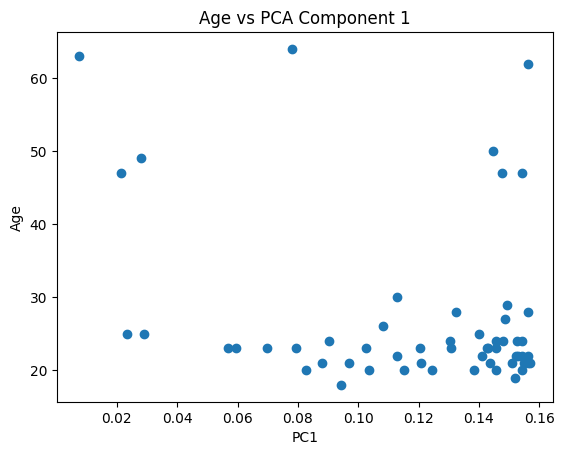

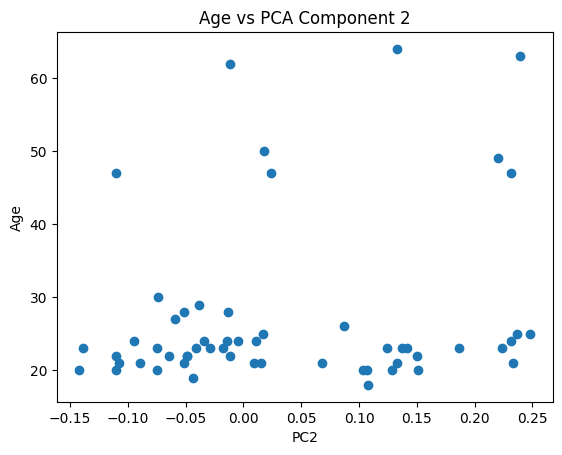

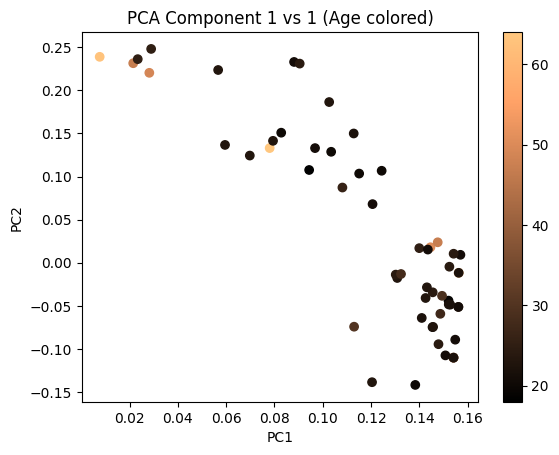

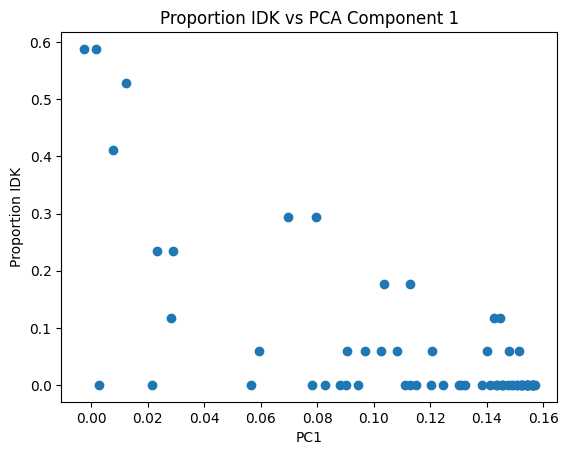

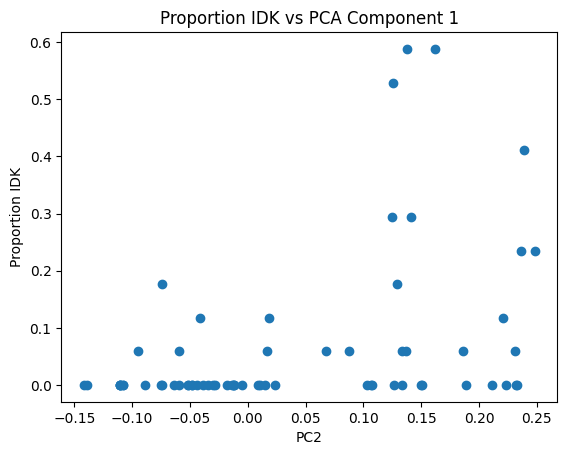

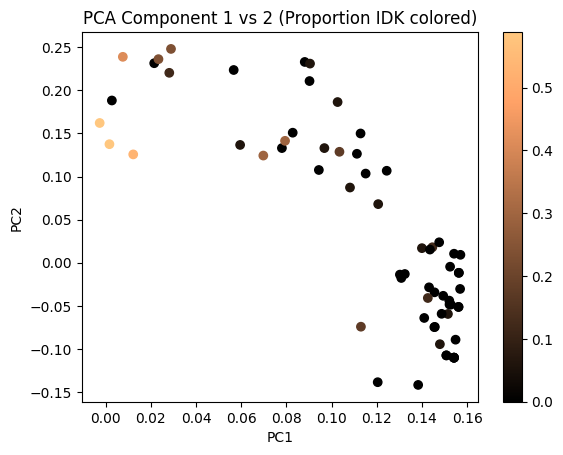

In [14]:
pca = PCA()
pca.fit(encoded.transpose())


plt.title('Age vs PCA Component 1')
plt.xlabel('PC1')
plt.ylabel('Age')
plt.scatter(pca.components_[0],data['Age'])
plt.show()
plt.title('Age vs PCA Component 2')
plt.xlabel('PC2')
plt.ylabel('Age')
plt.scatter(pca.components_[1],data['Age'])
plt.show()
plt.title('PCA Component 1 vs 1 (Age colored)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.set_cmap('copper')
plt.scatter(pca.components_[0],pca.components_[1],c=data['Age'])
plt.colorbar()
plt.show()
plt.title('Proportion IDK vs PCA Component 1')
plt.xlabel('PC1')
plt.ylabel('Proportion IDK')
plt.scatter(pca.components_[0],proportionIDK)
plt.show()
plt.title('Proportion IDK vs PCA Component 1')
plt.xlabel('PC2')
plt.ylabel('Proportion IDK')
plt.scatter(pca.components_[1],proportionIDK)
plt.show()
plt.title('PCA Component 1 vs 2 (Proportion IDK colored)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.set_cmap('copper')
plt.scatter(pca.components_[0],pca.components_[1],c=proportionIDK)
plt.colorbar()
plt.show()

After looking at the PCA for the participants, we can also compare the questions to each other using PCA. This is a little harder for the one-hot-encoded data since each column gets a separate PCA analysis, but we will graph both the one-hot-encoded and the mapped data below. The graphs basically show how similar the questions are to one another in terms of the first 2 PCA components.

In [15]:
from matplotlib.colors import ListedColormap
from matplotlib import colormaps


cmap = ['lightcoral','indianred',
        'lightsalmon','coral','darkorange',
        'orange',
        'gold','goldenrod','darkgoldenrod',
        'lightgoldenrodyellow','lemonchiffon',
        'khaki','olive','darkolivegreen',
        'greenyellow','chartreuse','lime',
        'limegreen','green','darkgreen',
        'aquamarine','turquoise','lightseagreen',
        'azure','lightcyan','paleturquoise','powderblue',
        'darkturquoise','cadetblue','darkcyan','teal','darkslategrey','darkslategray',
        'lightblue','lightskyblue','skyblue','deepskyblue','dodgerblue','steelblue',
        'lightsteelblue','cornflowerblue','royalblue',
        'blue','mediumblue','darkblue','navy','midnightblue',
        'thistle','plum','mediumorchid','darkorchid','darkviolet','blueviolet','rebeccapurple',
        'pink','hotpink','deeppink','mediumvioletred','crimson',
        'lightgrey','darkgrey','grey','dimgrey','black'
        ]

cmap2 = ['lightcoral',
        'coral',
        'orange',
        'gold',
        'lemonchiffon',
        'olive',
        'lime',
        'green',
        'turquoise',
        'lightcyan',
        'teal',
        'dodgerblue',
        'royalblue',
        'navy',
        'darkviolet',
        'mediumvioletred',
        'grey']
len(cmap)
cmap = ListedColormap(cmap)


#colormaps.register(cmap,name='mycmap')


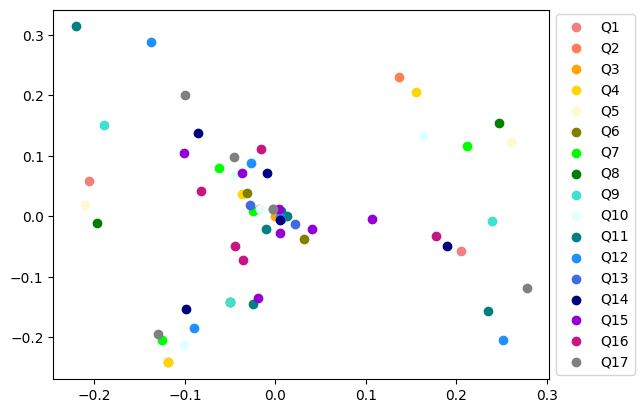

In [16]:
# now we look at the questions against each other
l = [2,3,1,3,3,2,4,3,3,4,6,6,3,5,7,5,5]
pca.fit(encoded)

# run this one if you want to see each col of each question a different shade
'''index = 0
for i in range(17):
    for j in range(l[i]):
        plt.scatter(pca.components_[0][index],pca.components_[1][index],label=qcols[i],color=cmap2[i])
        index += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()'''

# run this one for each col of each question the same color
index = 0
for i in range(17):
    plt.scatter(pca.components_[0][index:index+l[i]],pca.components_[1][index:index+l[i]],label=qcols[i],color=cmap2[i])
    index += l[i]
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

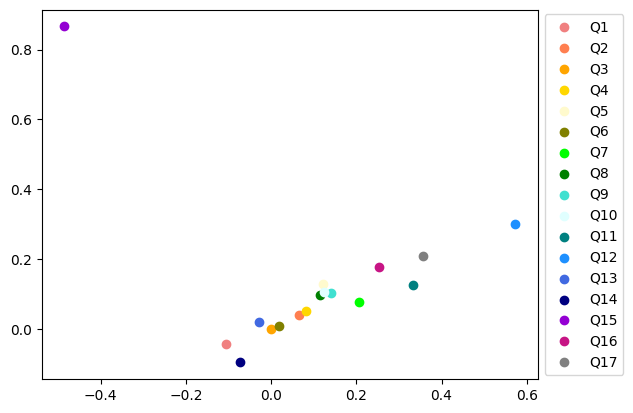

In [17]:
pca.fit(df)
index = 0
for i in range(17):
    plt.scatter(pca.components_[0][i],pca.components_[1][i],label=qcols[i],color=cmap2[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<h2>Column by Column Analysis</h2>
Below you will find the analysis we did to see if age was correlated with any of the specific question responses, as well as if any one question response was correlated to another question response. Below, we look at if age is correlated with the response to each individual question. The three questions with statistically significant differences in age between responses were questions 7, 10, and 16.


<h3>Age Analysis</h3>
To look at correlation between ages and responses to each specific question, we do anova tests to look for differences in all the questions and identify those with significant differences.

In [18]:
# does the pVal test for every question and prints the ones with significant p-vals
# for one-hot-encoded data
encoded['Age']=data['Age']
for q in encoded.columns:
    try:
        val = pValTest(encoded,q)[1]
    except:
        print('Test not done for column: '+q+'-- sample size too small')
    if val<0.05:
        print("Significant difference in " + q)
        print(val)


# for mapped data
df['Age']=data['Age']
for q in qcols:
    try:
        val = pValTest(df,q)[1]
    except:
        print('Test not done for column: '+q+'-- sample size too small')
    if val<0.05:
        print("Significant difference in " + q)
        print(val)

Test not done for column: Q3-Teacher-- sample size too small
Significant difference in Q7-Listener
1.357312786872568e-05
Significant difference in Q10-Cat
1.3229058875488091e-05
Significant difference in Q10-Listener
0.00019403553874668266
Significant difference in Q12-I don't know
0.034005155326176824
Significant difference in Q16-Mother
0.00023359858747474613
Test not done for column: Q3-- sample size too small
Significant difference in Q7
0.00014913261986476695
Significant difference in Q10
3.6451777242029974e-05
Significant difference in Q16
0.0022846876819149833


/Users/zoestephens/Desktop/summer2024/zstephe.github.io/honorifics/functions.py:100: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  result = f_oneway(*rows,nan_policy="omit")
/Users/zoestephens/Desktop/summer2024/zstephe.github.io/honorifics/functions.py:100: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  result = f_oneway(*rows,nan_policy="omit")
/Users/zoestephens/Desktop/summer2024/zstephe.github.io/honorifics/functions.py:100: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  result = f_oneway(*rows,nan_policy="omit")


Now that we have identified the statistically significant questions, we will look more closely at each question and see which specific responses had different age ranges. We are only looking at questions 7, 10, and 16 (not at q12 since it only showed up in one run and only for the idk values)

<h4>Question 7</h4>
Question text: This thought is nice.

The "Listener" response has a significantly higher mean than all the other responses.

In [20]:
# looking at Question 7
# appears to be a higher age with the Listener answer, but not many datapoints
# examineQuestion("Q7",questions,df["Age"])
examineQuestion("Q7-Listener",encoded,encoded['Age'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -27.616     0.000   -39.183   -16.049
 (1 - 0)     27.616     0.000    16.049    39.183

Counts of each Response
Q7-Listener
0    62
1     4
Name: count, dtype: int64

Group Means
0 : 25.71698113207547

1 : 53.333333333333336



<h4>Question 10</h4>
Question text: The cat is big.

The "Cat Owner" response was not included in the tukey test since there was only one such response.
The "Listener" response has a significantly higher mean than all the other responses (excluding cat owner), and the "Cat" response had a significantly lower age range than the other responses. It is worth noting that there were not many "Listener" responses.

In [24]:
# looking at Question 10
# appears to have a higher age with Listener and Cat owner responses but not many responses
examineQuestion("Q10-Cat",encoded,encoded['Age'])
examineQuestion("Q10-Listener",encoded,encoded['Age'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -20.127     0.000   -28.544   -11.710
 (1 - 0)     20.127     0.000    11.710    28.544

Counts of each Response
Q10-Cat
1    56
0    10
Name: count, dtype: int64

Group Means
1 : 25.04

0 : 45.166666666666664

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -29.352     0.000   -44.063   -14.641
 (1 - 0)     29.352     0.000    14.641    44.063

Counts of each Response
Q10-Listener
0    63
1     3
Name: count, dtype: int64

Group Means
0 : 26.14814814814815

1 : 55.5



<h4>Question 16</h4>
Question text: Mother’s murderer was cruel.

The "Mother" response has a significantly higher mean than the other responses.

In [26]:
# looking at Question 16
# appears to have a higher age with Mother but not many responses
# tukey shows difference between (Mother and Murderer) and (Mother and Listener)

# participants who picked "Mother" older than those who picked "Murderer" or "Listener"
#examineQuestion("Q16",questions,df['Age'])
examineQuestion("Q16-Mother",encoded,df['Age'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -18.890     0.000   -28.495    -9.285
 (1 - 0)     18.890     0.000     9.285    28.495

Counts of each Response
Q16-Mother
0    61
1     5
Name: count, dtype: int64

Group Means
0 : 25.50980392156863

1 : 44.4



<h3>Response Correlation Analysis</h3>
Now we will look at each column and see if the response in one column is correlated with the response in another column.

In [27]:
# run the cell in order to look at all significant effects of a response on another question's responses
'''for q1 in qcols:
    for q2 in qcols:
        if q1==q2:
            break
        p_vals, percents = compareCols(questions[q1],questions[q2])
        for p in range(1,len(p_vals)):
            if p_vals[p]<0.05:
                print("\n--------------------")
                print("First Column: "+q1)
                print("Second Column: "+q2)
                print("First Column answer: "+questions[q1].unique()[p])
                print("p-val: "+str(p_vals[p]))
                print("Second Column Responses: "+str(questions[q2].unique()))
                print("Overall percents: "+ str(percents[0]))
                print("Percents with Specific Col 1 Reponse: "+ str(percents[p+1]))'''

'for q1 in qcols:\n    for q2 in qcols:\n        if q1==q2:\n            break\n        p_vals, percents = compareCols(questions[q1],questions[q2])\n        for p in range(1,len(p_vals)):\n            if p_vals[p]<0.05:\n                print("\n--------------------")\n                print("First Column: "+q1)\n                print("Second Column: "+q2)\n                print("First Column answer: "+questions[q1].unique()[p])\n                print("p-val: "+str(p_vals[p]))\n                print("Second Column Responses: "+str(questions[q2].unique()))\n                print("Overall percents: "+ str(percents[0]))\n                print("Percents with Specific Col 1 Reponse: "+ str(percents[p+1]))'

After going through all the responses that significantly impacted other questions' responses, there were two patterns that stood out. First, for many questions, people who put "I don't know" or "Other" were more likely to put "I don't know" on other questions. The second pattern was that people who put "Listener" in certain questions (4,7,10) were more likely to also put "Listener" in other questions (2,4,2 respectively). Other than these, there were few significant correlations found.

### Overall

The most significant findings of this analysis are as follows:
- The proportion of IDK responses was used significantly in clustering and also correlated with PCA analysis
- There are possible age differences between responders in questions 7, 10, and 16
- People who put "I don't know" as a response to one question were more likely to do the same in other questions
- People who put "Listener" in certain questions were more likely to do the same in other questions